In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver
from devito import clear_cache, TimeFunction, Operator, Function
from devito.logger import set_log_level
from sympy import Eq, solve, cos, sin, sqrt,exp, diff, simplify, expand
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [65]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= .1 * h / (max(velocity))
        return 1e-6

# Manufacture solution

put ref

We use athe method of manufactured solution with theoretical solution as a polynomial in space (6th order to guaranty FD  still has an error to measure up to 6th order), and sine in time

In [66]:
def d1(xx, size, order):
    roots = np.linspace(0.+.5*float(order)/size, 2.0-.5*float(order)/size, order)
    xno = 2.0*xx/size
    return 1e3*simplify(expand((np.prod([(xno-r) for r in roots]))))

def mms(h, nn, spc, nt, c0=.58):
    clear_cache()
    set_log_level("DEBUG")

    modelloc = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn),
                          nbpml=spc, dtype=np.float64)
    dt = modelloc.critical_dt

    # Create symbols for forward wavefield, source and receivers
    u = TimeFunction(name='u', grid=modelloc.grid, save=nt,
                     time_order=2, space_order=spc)
    anlytic = TimeFunction(name='anlytic', grid=modelloc.grid, space_order=spc, save=nt)

    s = modelloc.grid.stepping_dim.spacing
    x, y = modelloc.grid.dimensions
    sol = (d1(x, modelloc.shape_domain[0], 6) *
           d1(y, modelloc.shape_domain[1], 6) *
           sin(c0*modelloc.grid.time_dim*dt/nt))

    source_term = (1.0/c0**2 * diff(sol, modelloc.grid.time_dim, 2) -
                   diff(sol, modelloc.grid.dimensions[0], 2) -
                   diff(sol, modelloc.grid.dimensions[1], 2))

    stencil = [Eq(u.forward, 2.0 * u - u.backward + c0**2 * dt**2 * u.laplace + c0**2 * dt**2 * source_term)]
    analytical = [Eq(anlytic, sol)]

    init_1 = [Eq(u.indexed[1, x, y], sol.subs({modelloc.grid.time_dim : 1.0}))]
    
    op = Operator(init_1 + stencil + analytical, dse='noop', dle='noop')
    summary = op.apply(time_s=0)
    return u, anlytic, summary, dt

# Verification

We compute the error between the numerical and analytical solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the erro for these parameters.

In [67]:

orders = ((2, ((401 , 1.0), (201, 2.0), (101, 4.0))),
           (4, ((401 , 1.0), (201, 2.0), (101, 4.0))),
           (6, ((401 , 1.0), (201, 2.0), (101, 4.0))))

shapes = ((401 , 1.0), (201, 2.0), (101, 4.0))
nt = 500

In [68]:
#Compute error in time

In [ ]:
errorl2 = np.zeros((3, 3))
timing = np.zeros((3, 3))


ind_o = -1
for order, gr in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in gr:
        ind_spc += 1
        clear_cache()
        u, analytical, summary, dt = mms(h, nn, order, nt)
        spc = order+1
        errorl2[ind_o, ind_spc] = np.max(np.fabs(u.data[nt-1, spc:-spc, spc:-spc] -
                                                   analytical.data[nt-1, spc:-spc, spc:-spc]))
        # minus error in time
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s runtime" %
              (order, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

ord = [2, 4, 8]

dx = [1.0, 2.0, 4.0]
with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, 3):
        plot.add_line(list(errorl2[i, :]), list(timing[i, :]), label=('order %s' % ord[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx][0:3])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

In [ ]:
print(timing)

In [ ]:
print(errorl2)

In [ ]:
plt.figure()
plt.loglog([1.0, 2.0, 4.0], errorl2[0,:])
plt.loglog([1.0, 2.0, 4.0], errorl2[1,:])
plt.loglog([1.0, 2.0, 4.0], errorl2[2,:])
plt.loglog(dx, [dd**2 for dd in dx])
plt.loglog(dx, [dd**4 for dd in dx])
plt.loglog(dx, [dd**8 for dd in dx])
plt.show()

In [ ]:
1.51512599e-04*16

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc for _, sc in sizes][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])
        plot.add_line([sc for _, sc in sizes][::-1], list(theory), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

In [58]:
nt = 500
u1, analy1, _, _ = mms(1.0, 401, 2, nt)
u2, analy2, _, _ = mms(1.0, 401, 4, nt)
u3, analy3, _, _ = mms(1.0, 401, 6, nt)

Allocating memory for damp ((405, 405))
Allocating memory for anlytic ((500, 405, 405))
Allocating memory for u ((500, 405, 405))
GNUCompilerNoAVX: compiled /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-pc9U5V/624ba044483ea5f84bd21ae2f5b8227f220aa737.c [0.17 s]
Section section_0<404,404> with OI=3.23 computed in 0.054 s [0.08 GFlops/s]
Section section_2<500,405,405> with OI=3.50 computed in 21.254 s [0.11 GFlops/s]
Section main<499,404,404> with OI=6.33 computed in 51.948 s [0.16 GFlops/s, 0.00 GPts/s]
Allocating memory for damp ((409, 409))
Allocating memory for anlytic ((500, 409, 409))
Allocating memory for u ((500, 409, 409))
GNUCompilerNoAVX: compiled /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-pc9U5V/c9c059e3357a31e126148f596cd0f09934f4530f.c [0.39 s]
Section section_0<407,407> with OI=3.22 computed in 0.047 s [0.09 GFlops/s]
Section section_2<500,409,409> with OI=3.50 computed in 21.303 s [0.11 GFlops/s]
Section main<499,407,407> with OI=7.04 computed in 52

# Plot

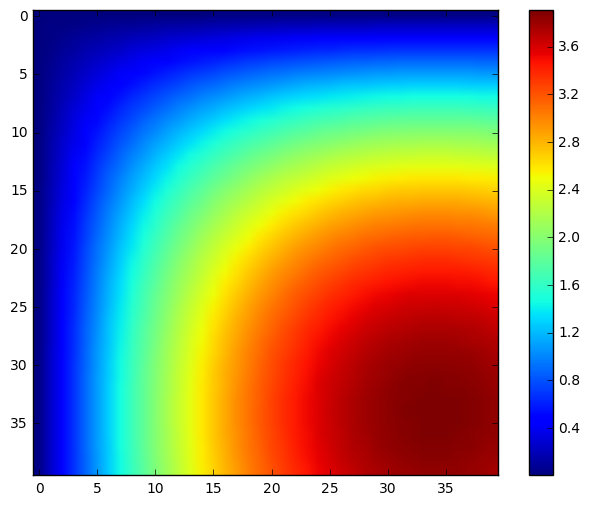

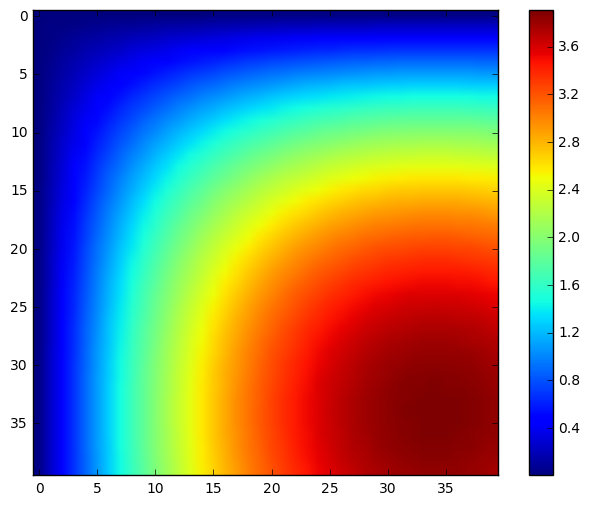

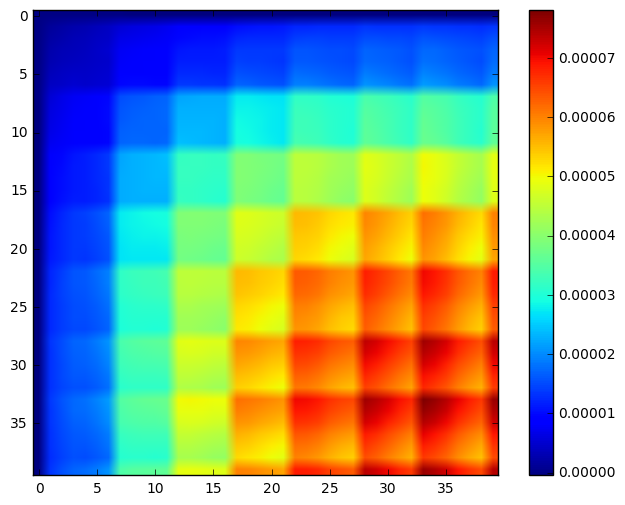

In [59]:
ti=nt-1
spc=2
npo = 100
center = npo + spc

plt.figure()
plt.imshow(u1.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy1.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u1.data[ti, center-20:center+20, center-20:center+20] -
           analy1.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()

In [60]:
np.linalg.norm((u1.data[ti, center-20:center+20, center-20:center+20] -
                analy1.data[ti, center-20:center+20, center-20:center+20]).reshape(-1), np.inf)

7.8005075294651505e-05

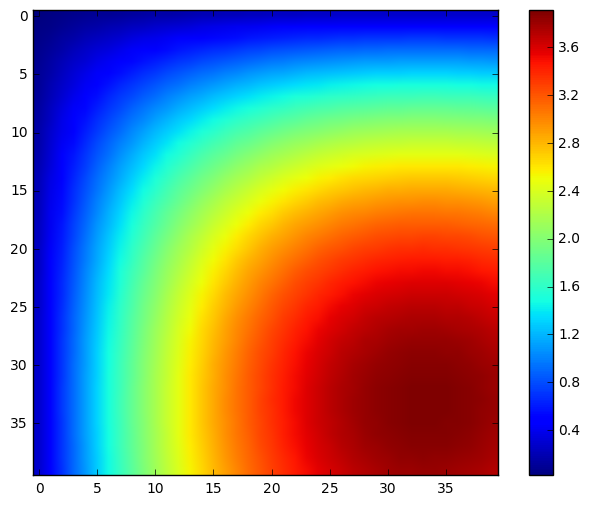

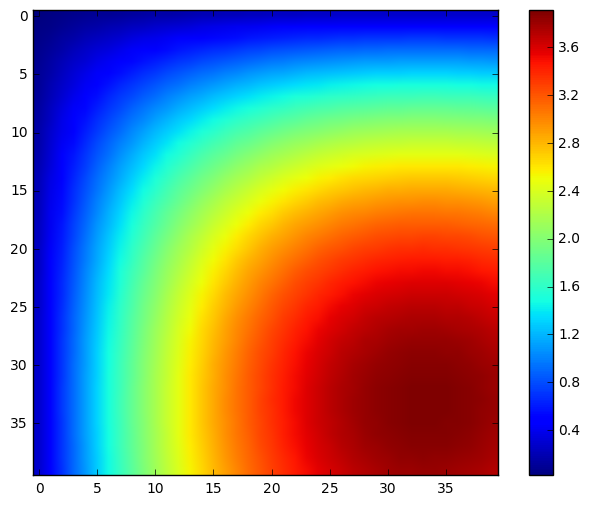

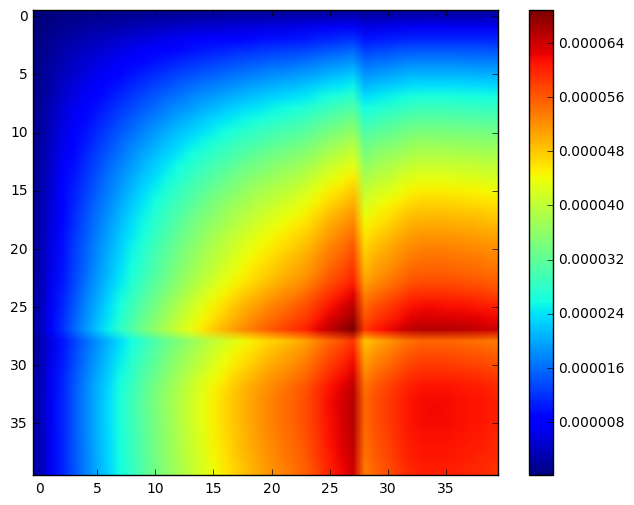

In [61]:
ti=nt-1
spc=4
center = npo + spc
plt.figure()
plt.imshow(u2.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy2.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u2.data[ti, center-20:center+20, center-20:center+20] -
           analy2.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()

In [62]:
np.linalg.norm((u2.data[ti, center-20:center+20, center-20:center+20] -
                analy2.data[ti, center-20:center+20, center-20:center+20]).reshape(-1), np.inf)

6.8792788672222827e-05

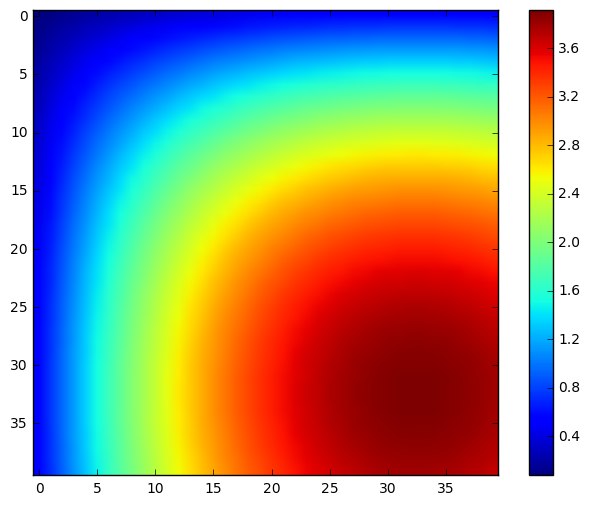

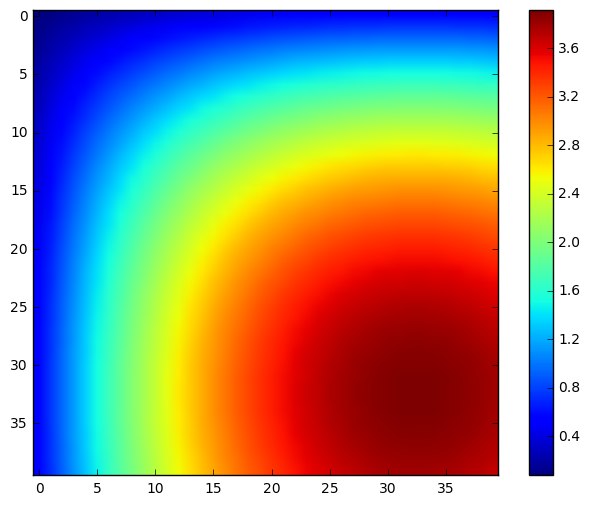

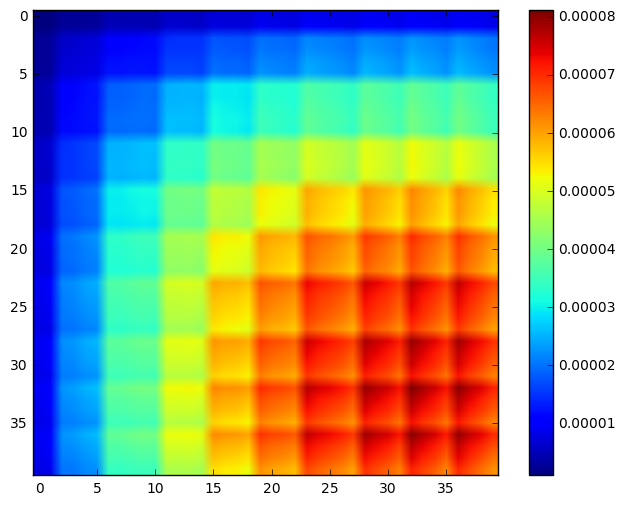

In [63]:
ti=nt-1
spc=6
center = npo + spc
plt.figure()
plt.imshow(u3.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy3.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u3.data[ti, center-20:center+20, center-20:center+20] -
           analy3.data[ti, center-20:center+20, center-20:center+20])
plt.colorbar()
plt.show()

In [64]:
np.linalg.norm((u3.data[nt-1, center-20:center+20, center-20:center+20] -
                analy3.data[nt-1, center-20:center+20, center-20:center+20]).reshape(-1), np.inf)

8.1045769410703627e-05